# Case study: The Rate of Convergence of ABC models

The aim of this notebook is to study how ELFI environment can be used to investigate how dimension of summary static affects to computational cost of ABC model. This notebook is aveilable online at: https://github.com/OssiGalkin/zoo/blob/master/Convergence/ConvergenceOfABC.ipynb.

This notebook is done as a part of course CS-E4070 - Special Course in Machine Learning and Data Science: Seminar Course on Approximate Bayesian Computation, on spring 2018 in Aalto University.

Author: [Ossi Galkin](https://github.com/OssiGalkin)

## Theoretical background

According to the paper "The Rate of Convergence for Approximate Bayesian Computation" (Stuart Barber, Jochen Voss, Mark Webster, 2015, https://arxiv.org/abs/1311.2038):

The error of an ABC estimate is affected both by the bias of the ABC samples, controlled by the tolerance parameter $\delta$, and by Monte Carlo error, controlled by the number n of accepted ABC samples

The computational cost of ABC model satisfies:


$$ cost \sim n * \delta ^{-q} $$

where n is number of accepted samples and q is dimension of summary statistic. $\delta$ is tolerance parameter. And under optimal choice of $\delta$:

$$ error \sim cost^{-2/(q+4)} $$


In above all parameters can be varied, so investigating them is started by varying dimension of summary statistic, because number of accepted samples or threshold are trivially changeable parameters. 

## How dimension of summary statistic affects the cost of ABC

This example follows same conventions that are used in [ELFI tutorial](https://elfi.readthedocs.io/en/latest/usage/tutorial.html). Basically 6 variate normal distribution is created with means [1, 3, -2, 0, -4, 0] and covariance matrix:

       [[ 0.54283214, -0.01897608,  0.09250538, -0.29508488,  0.20071569,  0.10224879],
       [-0.01897608,  3.17949029, -0.16261362,  3.01116863, -0.05390658,  0.01796679],
       [ 0.09250538, -0.16261362,  0.60222194,  0.0543998 ,  0.0066263 , -0.01040673],
       [-0.29508488,  3.01116863,  0.0543998 ,  3.79268361, -0.1132359 , -0.07189611],
       [ 0.20071569, -0.05390658,  0.0066263 , -0.1132359 ,  0.46941068,  0.14608359],
       [ 0.10224879,  0.01796679, -0.01040673, -0.07189611,  0.14608359,  0.49294955]]
       
and ABC model is set to generate samples from that distributions. This is not very complicated problem and it could be solved statistically without ABC methods, but it makes easy to investigate how dimension of summary statistic affects results.

In each case 100 samples are drawn from model with tolerance 0.5. This is done for 6, 3, 2, and 1 dimensional summary statistics. In addition, two different summary statistics are used for 3 and 2 dimensional cases.

Following code cell defines model and 6-dimensional summary statistic and performs all necessary imports.


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 13 09:34:36 2018

@author: ossig
"""
import elfi
import numpy as np
import matplotlib.pyplot as plt
import logging
import scipy as sp
from sklearn import datasets
import scipy.stats as ss
import numpy as np

logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter

#elfi.set_client('multiprocessing')

%matplotlib inline
%precision 2

# Set an arbitrary seed and a global random state to keep the randomly generated quantities the same between runs
# NoteToSelf: Statement above is not true, see bug 268
seed = 20170530
np.random.seed(seed)


# Priors indexing starts at 1, as in ELFI introduction, othervice indexing starts a 0 tought
prior1 = elfi.Prior('uniform', -2, 4)
prior2 = elfi.Prior('uniform', 1, 4)
prior3 = elfi.Prior('uniform', -3, 4)
prior4 = elfi.Prior('uniform', -2, 4)
prior5 = elfi.Prior('uniform', -6, 4)
prior6 = elfi.Prior('uniform', -1, 4)

# Set the generating parameters that we will try to infe
mean0 = [1]
mean1 = [3]
mean2 = [-2]
mean3 = [0]
mean4 = [-4]
mean5 = [0]

cov = datasets.make_spd_matrix(6)


# Simulator for 6 variate distribution
def simulator(mean0, mean1, mean2, mean3, mean4, mean5, random_state=None, batch_size=1):
    assert batch_size == 1, " Batch sizes other than 0 won't work :("
    mean0, mean1, mean2, mean3, mean4, mean5 = np.atleast_1d(mean0, mean1, mean2, mean3, mean4, mean5)
    
    # wrap means to 1d array
    means = [] 
    means.append(mean0[0])
    means.append(mean1[0])
    means.append(mean2[0])
    means.append(mean3[0])
    means.append(mean4[0])
    means.append(mean5[0])
    
    # following takes global variable cov as input, as I didn't figure out how to pass constants in Elfi
    return sp.stats.multivariate_normal.rvs(mean=means, cov=cov, size=(batch_size, 30), random_state=random_state)
    

def mean(y, i=0, j=None):
    # NoteToSelf: y is not a numpy array
    # NoteToSelf: if batch_size = 1 elfi uses different dimensions.
    if j == None:
        return np.mean(y[i], axis=0)
    else:
        return np.mean(np.mean(y[:, i:j], axis=0))
    
# Generate some data
y0 = simulator(mean0, mean1, mean2, mean3, mean4, mean5)

# Add the simulator node and observed data to the model
sim = elfi.Simulator(simulator, prior1, prior2, prior3, prior4, prior5, prior6, observed=y0)

# Add summary statistics to the model
S1 = elfi.Summary(mean, sim, 0)
S2 = elfi.Summary(mean, sim, 1)
S3 = elfi.Summary(mean, sim, 2)
S4 = elfi.Summary(mean, sim, 3)
S5 = elfi.Summary(mean, sim, 4)
S6 = elfi.Summary(mean, sim, 5)

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data

d = elfi.Distance('euclidean', S1, S2, S3, S4, S5, S6)

pool = elfi.OutputPool(['prior1', 'prior2', 'prior3', 'prior4', 'prior5', 'prior6', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6'])

amountOfSimulations = []
amountOfDimensions = [] 

tolerance = 0.5
N = 100


In [2]:
# NoteToSelf: why seed is passed again?
rej = elfi.Rejection(d, batch_size=1, seed=30052017, pool=pool) 
res = rej.sample(N, threshold=tolerance)
print("6", res)

amountOfSimulations.append(res.n_sim)
amountOfDimensions.append(6)


6 Method: Rejection
Number of samples: 100
Number of simulations: 199485
Threshold: 0.5
Sample means: prior1: -0.31, prior2: 2.7, prior3: -1.35, prior4: -0.203, prior5: -4.39, prior6: 0.626



Now change summary statistic and generate samples for them.

In [3]:
# Three dimension summary statistic

S12 = elfi.Summary(mean, sim, 0, 1)
S34 = elfi.Summary(mean, sim, 2, 3)
S56 = elfi.Summary(mean, sim, 4, 5)

d.become(elfi.Distance('euclidean', S12, S34, S56))

rej = elfi.Rejection(d, batch_size=1, seed=30052017, pool=pool)  
res = rej.sample(N, threshold=tolerance)
print("3", res)

amountOfSimulations.append(res.n_sim)
amountOfDimensions.append(3)

# Three dimension summary statistic ((different than previous)

S1 = elfi.Summary(mean, sim, 0)
S2345 = elfi.Summary(mean, sim, 1, 4)
S6 = elfi.Summary(mean, sim, 5)


d.become(elfi.Distance('euclidean', S1, S2345, S6))

rej = elfi.Rejection(d, batch_size=1, seed=30052017, pool=pool)  
res = rej.sample(N, threshold=tolerance)
print("3", res)

amountOfSimulations.append(res.n_sim)
amountOfDimensions.append(3)

# Two dimension summary statistic

S12 = elfi.Summary(mean, sim, 0, 1)
S3456 = elfi.Summary(mean, sim, 2, 5)

d.become(elfi.Distance('euclidean', S12, S3456))

rej = elfi.Rejection(d, batch_size=1, seed=30052017, pool=pool)  
res = rej.sample(N, threshold=tolerance)
print("2", res)

amountOfSimulations.append(res.n_sim)
amountOfDimensions.append(2)


# Two dimension summary statistic (different than previous)

S123 = elfi.Summary(mean, sim, 0, 2)
S456 = elfi.Summary(mean, sim, 3, 5)

d.become(elfi.Distance('euclidean', S123, S456))

rej = elfi.Rejection(d, batch_size=1, seed=30052017, pool=pool)  
res = rej.sample(N, threshold=tolerance)
print("2", res)

amountOfSimulations.append(res.n_sim)
amountOfDimensions.append(2)

# One dimension summary statistic

S1233456 = elfi.Summary(mean, sim, 0, 5)

d.become(elfi.Distance('euclidean', S1233456))

rej = elfi.Rejection(d, batch_size=1, seed=30052017, pool=pool)  
res = rej.sample(N, threshold=tolerance)
print("2", res)

amountOfSimulations.append(res.n_sim)
amountOfDimensions.append(1)


3 Method: Rejection
Number of samples: 100
Number of simulations: 10463
Threshold: 0.5
Sample means: prior1: 0.956, prior2: 2.97, prior3: -2.2, prior4: 0.00762, prior5: -3.55, prior6: 0.812

3 Method: Rejection
Number of samples: 100
Number of simulations: 2603
Threshold: 0.498
Sample means: prior1: -0.311, prior2: 2.96, prior3: -1.67, prior4: -0.179, prior5: -4.15, prior6: 0.606

2 Method: Rejection
Number of samples: 100
Number of simulations: 1010
Threshold: 0.498
Sample means: prior1: 0.975, prior2: 2.95, prior3: -1.28, prior4: -0.0677, prior5: -4.42, prior6: 0.819

2 Method: Rejection
Number of samples: 100
Number of simulations: 947
Threshold: 0.498
Sample means: prior1: 0.523, prior2: 3.43, prior3: -1.2, prior4: 0.0957, prior5: -3.81, prior6: 0.892

2 Method: Rejection
Number of samples: 100
Number of simulations: 150
Threshold: 0.497
Sample means: prior1: 0.276, prior2: 2.95, prior3: -0.952, prior4: -0.0996, prior5: -3.94, prior6: 0.915



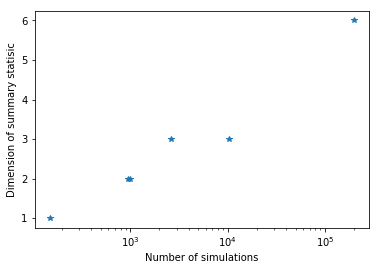

In [4]:
plt.figure()
plt.xlabel('Number of simulations')
plt.ylabel('Dimension of summary statisic')
plt.semilogx(amountOfSimulations, amountOfDimensions, "*")

As x-axis is logarithmic in plot above there is exponential relationship between dimension of summary statistic and number of simulations. This was intuitive for me at start, but using summary statistic that summarize more dimensions (and loose much more information) were incredibly faster, while maintaining same threshold level.

## Different distance

Sometimes it is not trivial or even possible to figure out different summary statistic for ABC model. However, it is possible to use different distances. Let’s make a brief scratch on those! 

Following defines same MA2 model as was used in ELFI introduction. It will also define autocorrelation as an alternative for autocovariance.


In [5]:
import scipy.stats

seed = 20170530
np.random.seed(seed)

N = 100

threshold = 0.5

def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    return x


# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = sp.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        
        return t1


# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = sp.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2


def autocov(x, lag=1):
    # BOF: introduction doesn't tfollow pep8, this happens elswhere too
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    #print(C.shape)

    
    return C


def autocorr(x):
    # print(x.shape)
    #result = np.correlate(x[0,:], x[0,:], mode='full')
    #return result[result.size/2:]
    
    #print(x.shape)
    ret = np.correlate(x[0,:], x[0,:], mode='same')
    
    #print(ret.shape)

    return np.mean(ret, axis=0)



# true parameters
t1_true = 0.6
t2_true = 0.2

y_obs = MA2(t1_true, t2_true)


t1 = elfi.Prior(CustomPrior_t1, 2)
t2 = elfi.Prior(CustomPrior_t2, t1, 1)

Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

pool = elfi.OutputPool(['t1', 't2', 'S1', 'S2'])
resultsArray = []

S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2
d = elfi.Distance('euclidean', S1, S2)

batch_size = 1

In [6]:
print("Starting rejection sampling...")

rej = elfi.Rejection(d, pool=pool, batch_size=batch_size, seed=seed)
result = rej.sample(N, threshold=threshold)
resultsArray.append(result.n_sim)

print("One rejection samplng done.")

# Replace the current distance with a cityblock (manhattan) distance and recreate the inference

d.become(elfi.Distance('cityblock', S1, S2, p=1))
rej = elfi.Rejection(d, pool=pool, batch_size=batch_size, seed=seed) # pool =10000
result = rej.sample(N, threshold=threshold)
resultsArray.append(result.n_sim)

print("Two rejection samplng done.")

S1.become(elfi.Summary(autocorr, Y))
S2.become(elfi.Summary(autocorr, Y))
d.become(elfi.Distance('euclidean', S1, S2, p=1))
rej = elfi.Rejection(d, pool=pool, batch_size=batch_size, seed=seed)
result = rej.sample(N, threshold=threshold)
print(result.summary)

print("Three rejection samplng done.")

d.become(elfi.Distance('cityblock', S1, S2, p=1))
rej = elfi.Rejection(d, pool=pool, batch_size=batch_size, seed=seed)
result = rej.sample(N, threshold=threshold)
resultsArray.append(result.n_sim)

print("Four rejection samplng done.")
print(result.summary)


Starting rejection sampling...
One rejection samplng done.
Two rejection samplng done.
<bound method Sample.summary of Method: Rejection
Number of samples: 100
Number of simulations: 5606
Threshold: 0.494
Sample means: prior1: 0.0204, prior2: 2.96, prior3: -1.02, prior4: -0.162, prior5: -4.19, prior6: 1.21, t1: 0.639, t2: 0.494
>
Three rejection samplng done.
Four rejection samplng done.
<bound method Sample.summary of Method: Rejection
Number of samples: 100
Number of simulations: 9498
Threshold: 0.492
Sample means: prior1: 0.124, prior2: 3.04, prior3: -1.03, prior4: 0.0785, prior5: -3.92, prior6: 1.41, t1: 0.62, t2: 0.534
>


As can be see model with autocorrelation as summary statistic produces wrong mean. Clearly one cannot use any summary statistic and expect convergence.

Next Sequential Monte Carlo ABC is used with different distance metrics.

In [7]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

    def pdf(x, b):
        p = 1./b - np.abs(x) / (b*b)
        p = np.where(p < 0., 0., p)  # disallow values outside of [-b, b] (affects weights only)
        return p


# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2

    def pdf(x, t1, a):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = scipy.stats.uniform.pdf(x, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)  # disallow values outside of [-a, a] (affects weights only)
        return p

schedule = [0.7, 0.2, 0.05]
N2 = 100  # 1000000

    
print("Starting Sequential Monte Carlo samplng...")

# Redefine the priors
t1.become(elfi.Prior(CustomPrior_t1, 2, model=t1.model))
t2.become(elfi.Prior(CustomPrior_t2, t1, 1))
S1.become(elfi.Summary(autocov, Y))
S2.become(elfi.Summary(autocov, Y))
d.become(elfi.Distance('euclidean', S1, S2))
smc = elfi.SMC(d, pool=pool, batch_size=1, seed=seed)
result_smc = smc.sample(N2, schedule)
# result_smc.sample_means_summary(all=True)
resultsArray.append(result_smc.n_sim)

print("One SMC smapling done.")

d.become(elfi.Distance('cityblock', S1, S2))
smc = elfi.SMC(d, pool=pool, batch_size=1, seed=seed)
result_smc = smc.sample(N2, schedule)
resultsArray.append(result_smc.n_sim)

print("Two SMC smapling done.")

INFO:elfi.methods.parameter_inference:---------------- Starting round 0 ----------------


Starting Sequential Monte Carlo samplng...


INFO:elfi.methods.parameter_inference:---------------- Starting round 1 ----------------
INFO:elfi.methods.parameter_inference:---------------- Starting round 2 ----------------
INFO:elfi.methods.parameter_inference:---------------- Starting round 0 ----------------


One SMC smapling done.


INFO:elfi.methods.parameter_inference:---------------- Starting round 1 ----------------
INFO:elfi.methods.parameter_inference:---------------- Starting round 2 ----------------


Two SMC smapling done.


Finally print how many simulations were needed to achieve samples with same threshold. First two are for rejection sampling and former two are for SMC. In each pair first, Euclidian distance is used then Manhattan distance.

In [8]:
print(resultsArray)

[614, 1042, 9498, 3076, 3792]


As acn be seen from saved number of iterations model with poor distance metric will use much more simulations.

## Final notes on ELFI

In gneral ELFI feels good but unstable enviroment for ABC computing. For example enabling multicore computing for this notebook produces following error on servers console and python kernel will need reboot to recover, I didn't figure clear reason for this, but in general using pools and multiple cores felt like road to misery:

```
Process SpawnPoolWorker-7:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\process.py", line 258, in _bootstrap
    self.run()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\pool.py", line 108, in worker
    task = get()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 337, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'simulator' on <module '__main__' (built-in)>
```

In addition I encoutred other ELFI related bugs and problems in basic operations like runing python file with ipython (see issues [267](https://github.com/elfi-dev/elfi/issues/267) and [268](https://github.com/elfi-dev/elfi/issues/268).

Also many times it is not evident what is data type or what is dimension of several objects that are manipulated in ELFI related operations. Example of these are marked with NoteToSelf in commnets in code cells. 